# 오버워치 2 점수판 분석 AI

In [1]:
import pandas as pd
from os import path
import joblib

players = 10


def prepare_scoreboards(defeat_, victory_):
    scoreboards_ = pd.concat([defeat_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, victory)
d_max = scoreboards['D'].max()
joblib.dump(d_max, 'max.joblib')
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = d_max
scoreboards

E  A   D   DMG     H   MIT     GAME
0   0  7  3   6  5933  1068  6199   DEFEAT
    1  7  0  10  3601   747     0   DEFEAT
    2  9  1   6  4352     0     0   DEFEAT
    3  7  7   2  2332  6325     0   DEFEAT
    4  6  4   2  3410  5979   606   DEFEAT
...   .. ..  ..   ...   ...   ...      ...
526 5  9  3   6  5799   769  2762  VICTORY
    6  7  0   9  5558     0   320  VICTORY
    7  7  0   7  4247     0     0  VICTORY
    8  6  3   7  1725  3551   412  VICTORY
    9  6  5   6  1330  4636   843  VICTORY

[5270 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5270 entries, (0, 0) to (526, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       5270 non-null   int64 
 1   A       5270 non-null   int64 
 2   D       5270 non-null   int64 
 3   DMG     5270 non-null   int64 
 4   H       5270 non-null   int64 
 5   MIT     5270 non-null   int64 
 6   GAME    5270 non-null   object
dtypes: int64(6), object(1)
memory usage: 324.3+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000
mean,13.801898,7.253131,6.427704,6208.883112,3834.459583,2400.703226
std,9.525138,8.120327,3.829393,4281.758425,5033.527722,4653.976048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2776.500000,0.000000,0.000000
50%,13.000000,4.000000,6.000000,5543.000000,764.500000,370.500000
75%,20.000000,12.000000,9.000000,9068.500000,7432.250000,2034.750000
max,58.000000,54.000000,21.000000,26666.000000,27756.000000,41849.000000


In [4]:
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
scoreboards

E  A   D   DMG     H   MIT     GAME
0   0  7  3   6  5933  1068  6199   DEFEAT
    1  7  0  10  3601   747     0   DEFEAT
    2  9  1   6  4352     0     0   DEFEAT
    3  7  7   2  2332  6325     0   DEFEAT
    4  6  4   2  3410  5979   606   DEFEAT
...   .. ..  ..   ...   ...   ...      ...
526 5  9  3   6  5799   769  2762  VICTORY
    6  7  0   9  5558     0   320  VICTORY
    7  7  0   7  4247     0     0  VICTORY
    8  6  3   7  1725  3551   412  VICTORY
    9  6  5   6  1330  4636   843  VICTORY

[5270 rows x 7 columns]

In [6]:
tank = pd.concat([scoreboards[::players], scoreboards[5::players]])
damage = pd.concat([scoreboards[1::players], scoreboards[2::players], scoreboards[6::players], scoreboards[7::players]])
support = pd.concat(
    [scoreboards[3::players], scoreboards[4::players], scoreboards[8::players], scoreboards[9::players]]
)

In [7]:
tank.describe()

,E,A,D,DMG,H,MIT
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,17.761860,4.247628,6.130930,9085.345351,378.085389,9731.416509
std,10.112531,3.719302,3.676616,4113.991553,1125.751565,6103.640761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,3.000000,6076.000000,0.000000,5444.500000
50%,17.000000,3.000000,6.000000,8872.500000,0.000000,8535.500000
75%,24.000000,6.000000,8.000000,11684.500000,24.000000,12952.750000
max,58.000000,24.000000,21.000000,24682.000000,15168.000000,41849.000000


In [8]:
damage.describe()

,E,A,D,DMG,H,MIT
count,2108.000000,2108.000000,2108.000000,2108.000000,2108.000000,2108.000000
mean,17.091556,1.906072,7.111480,8182.710626,342.912713,634.993833
std,9.155342,2.599277,4.064198,3638.327924,548.377683,1108.531087
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,4.000000,5557.250000,0.000000,0.000000
50%,16.000000,1.000000,7.000000,7822.500000,4.000000,81.000000
75%,23.000000,3.000000,10.000000,10466.750000,517.250000,823.000000
max,52.000000,18.000000,21.000000,26666.000000,3353.000000,9682.000000


In [9]:
support.describe()

,E,A,D,DMG,H,MIT
count,2108.000000,2108.000000,2108.000000,2108.000000,2108.000000,2108.000000
mean,8.532258,14.102941,5.892315,2796.824478,9054.193548,501.055977
std,6.745661,8.435710,3.549538,2113.366556,4122.333032,839.597275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,3.000000,1260.000000,6087.750000,0.000000
50%,7.000000,13.000000,6.000000,2468.500000,8616.500000,203.000000
75%,13.000000,19.000000,8.000000,3833.000000,11545.250000,623.250000
max,52.000000,54.000000,21.000000,16254.000000,27756.000000,7778.000000


그림 저장:tank_hist


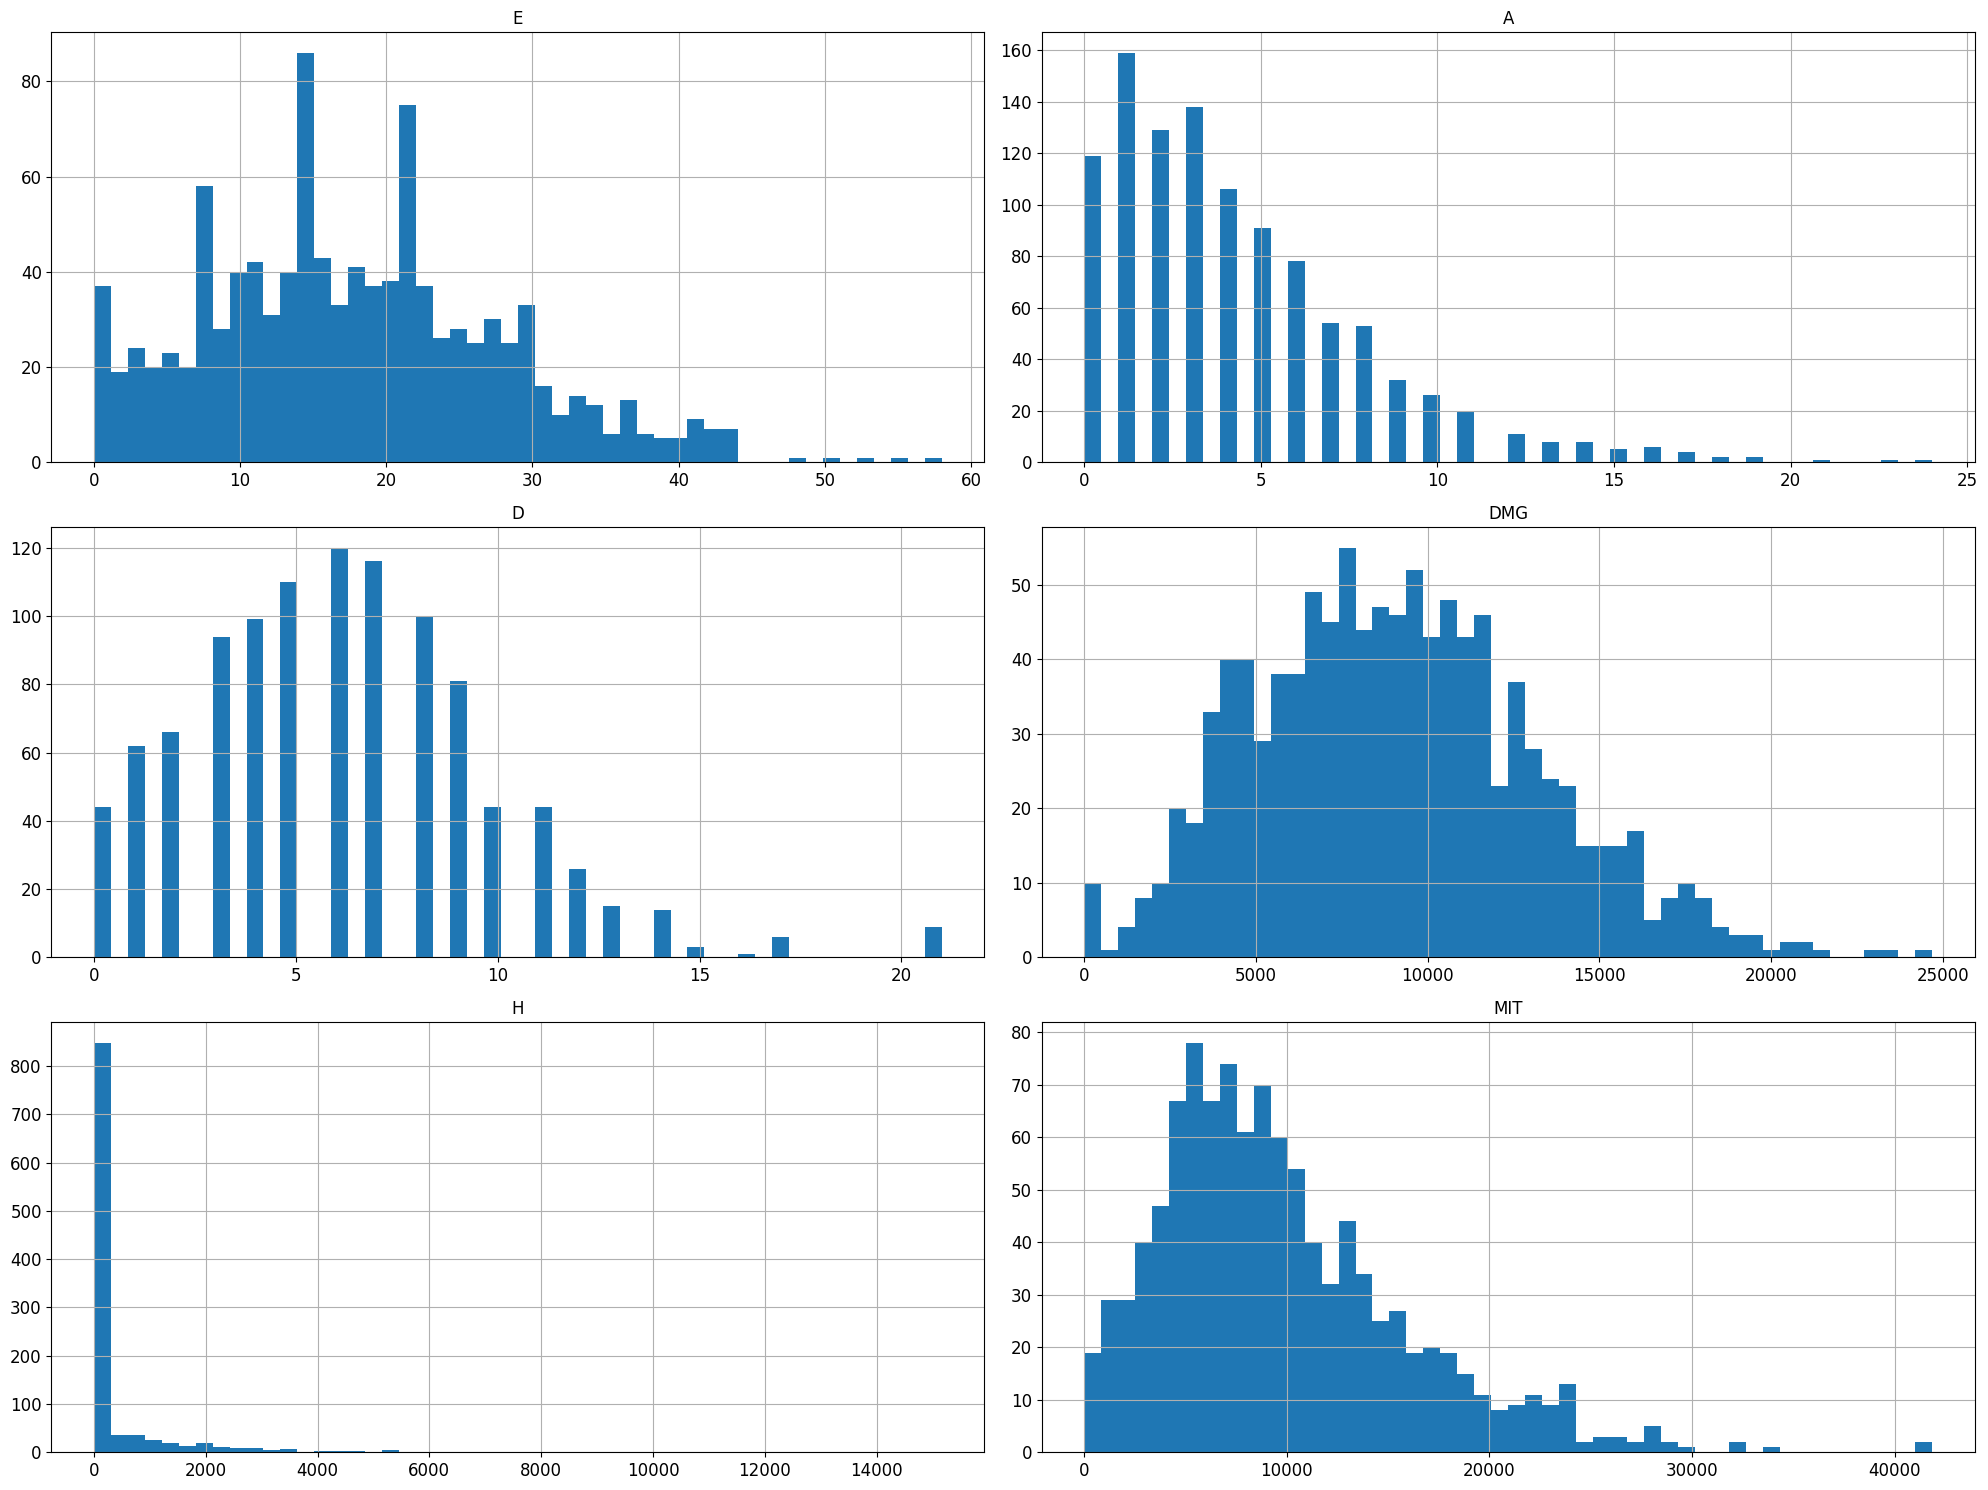

In [10]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


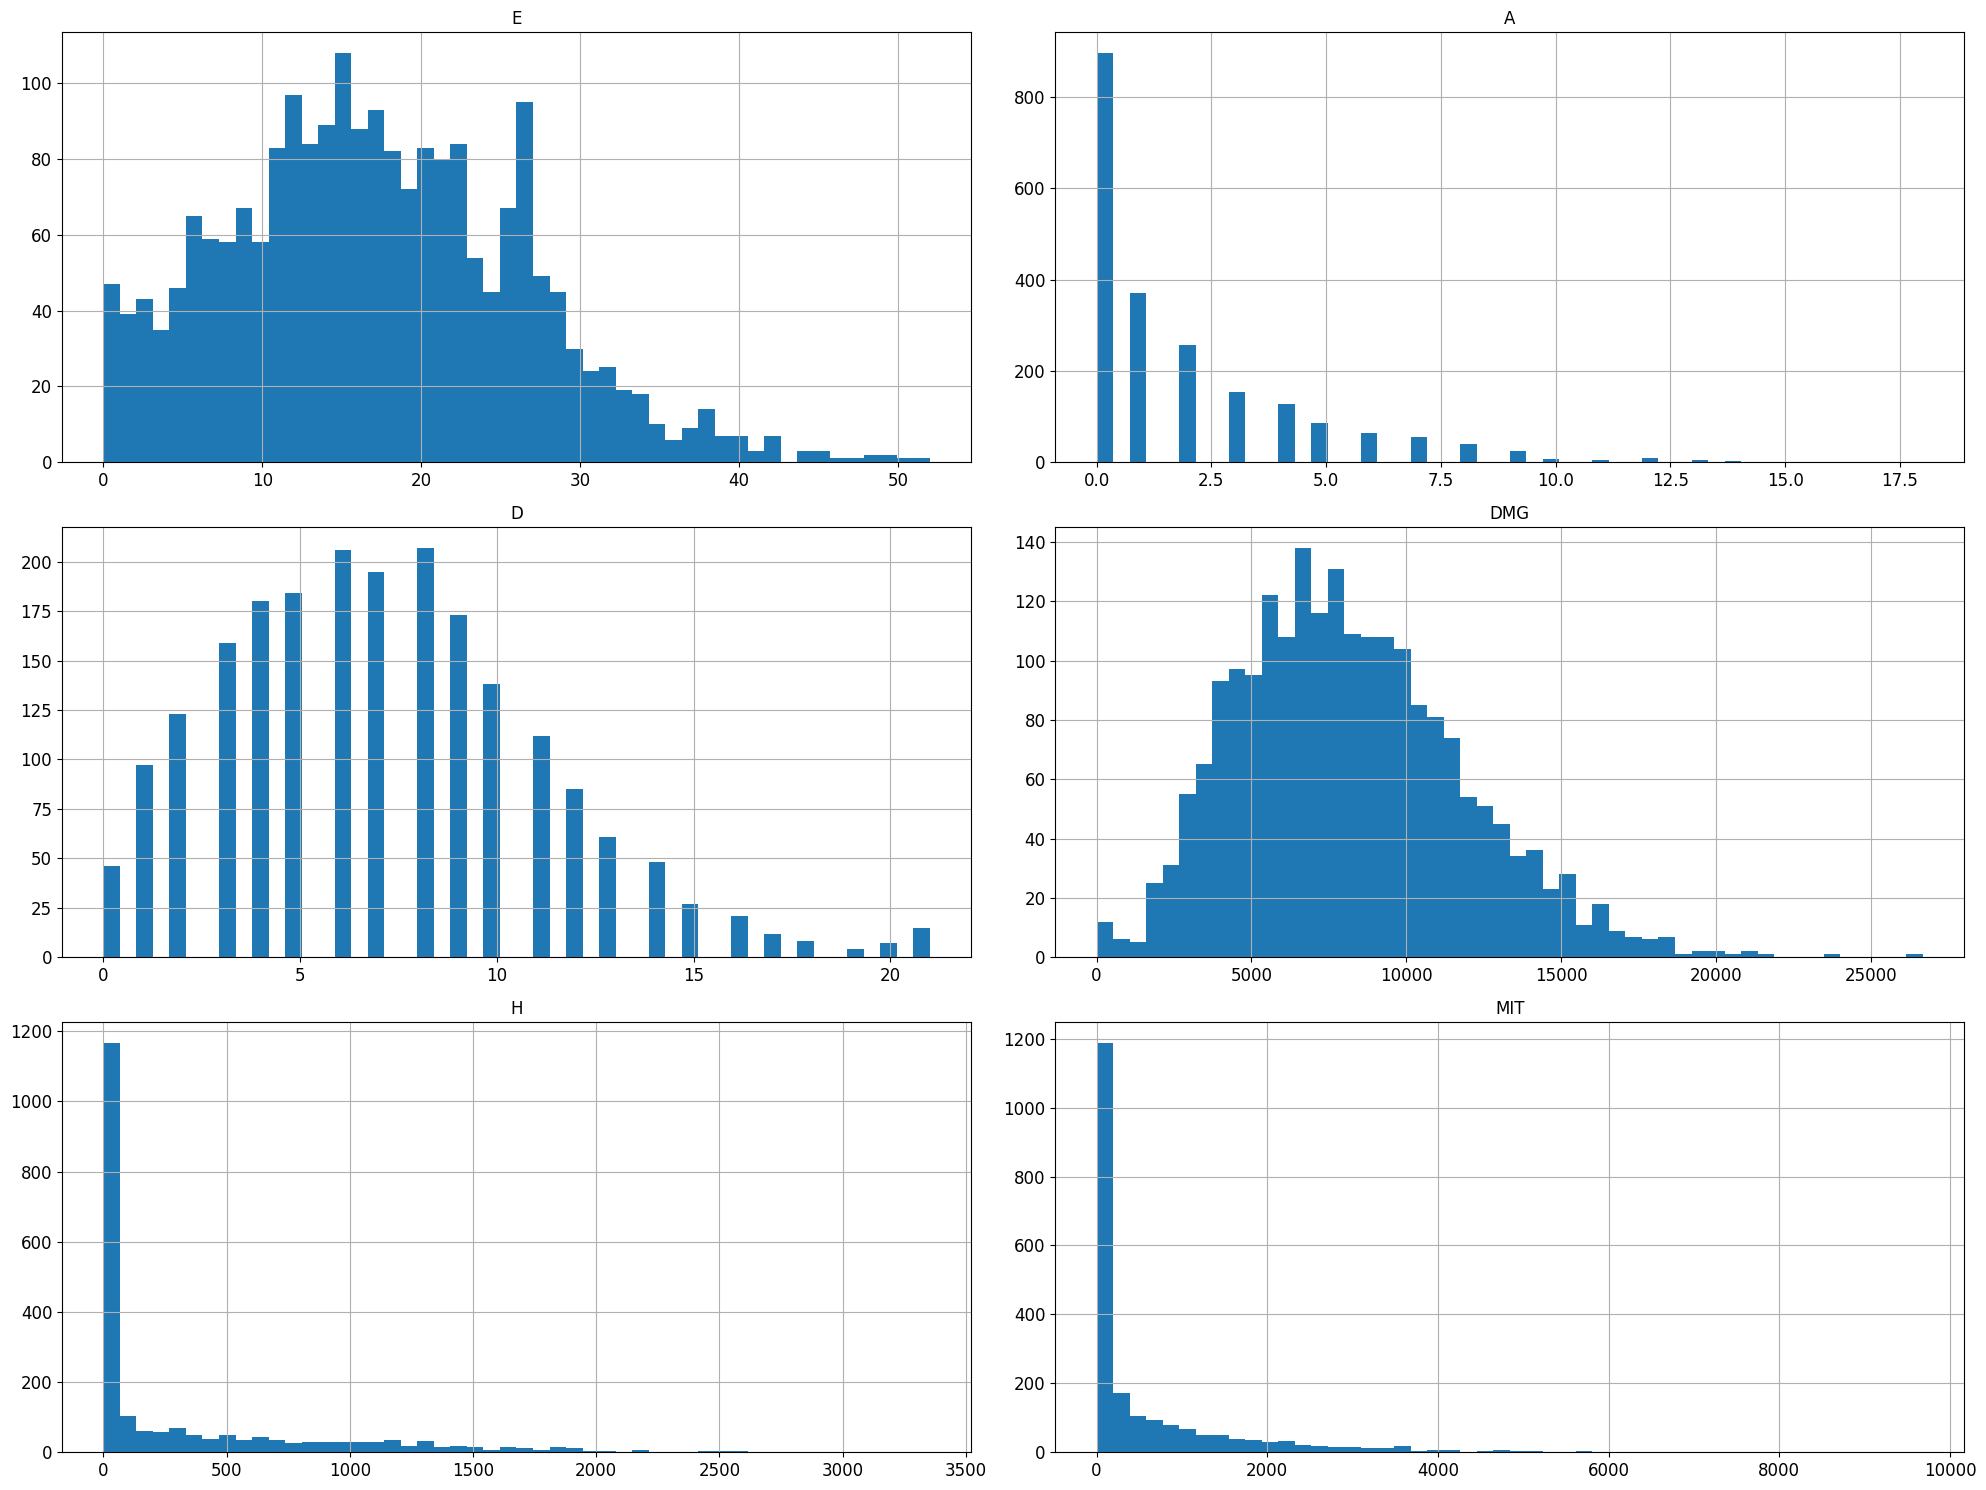

In [11]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


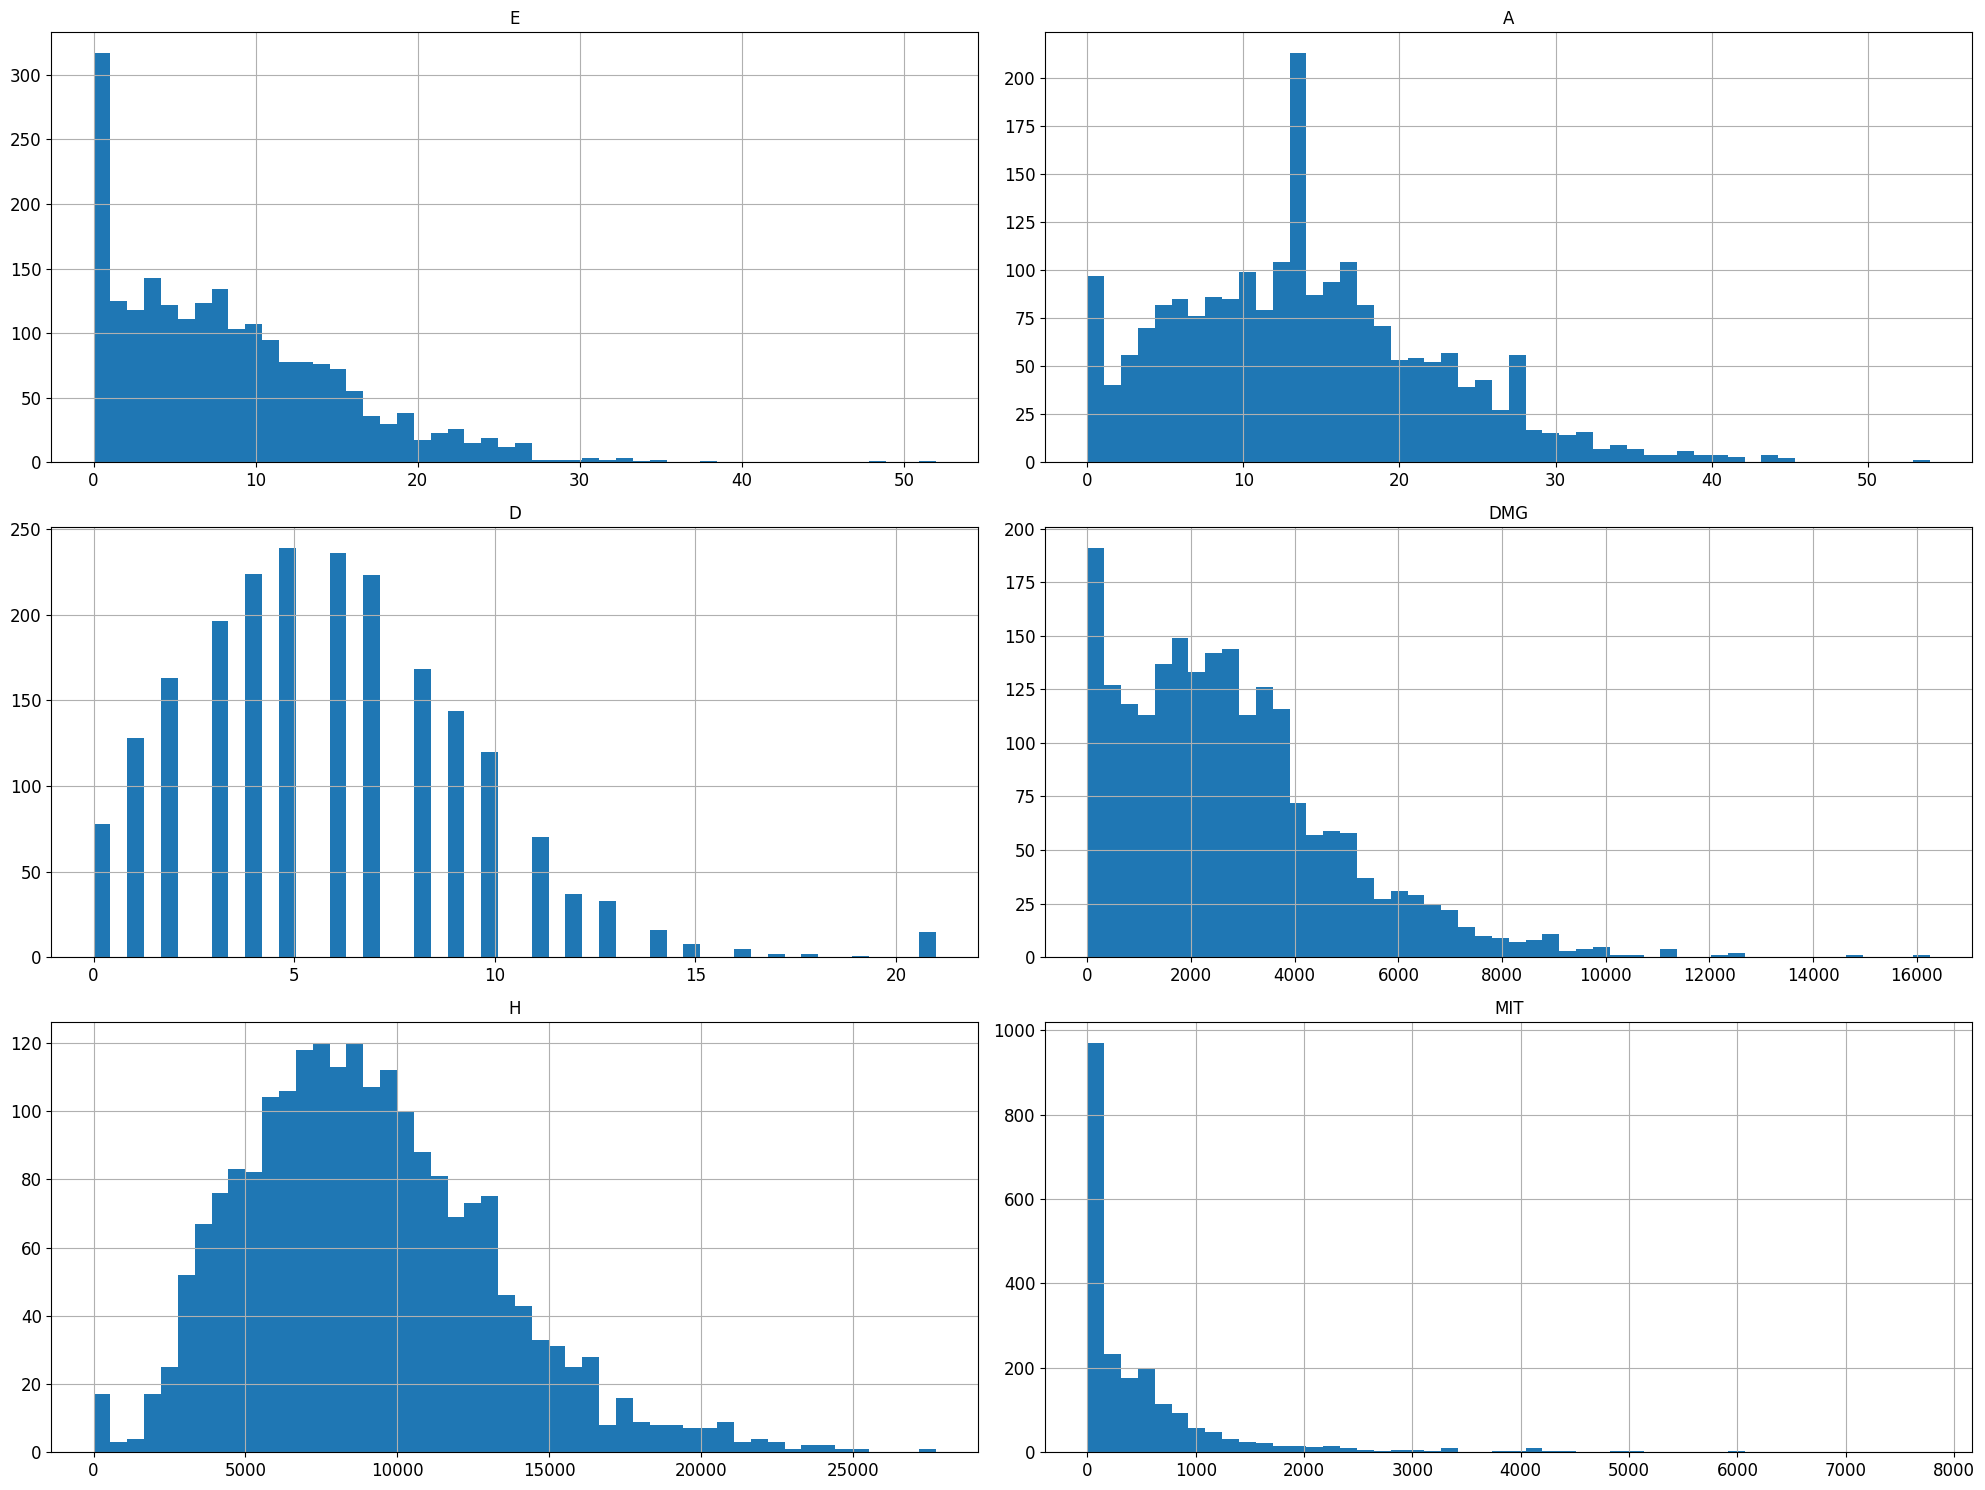

In [12]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [13]:
from sklearn import utils

scoreboards = scoreboards.loc[utils.shuffle(range(len(scoreboards.index) // players))]
scoreboards

E   A   D    DMG      H    MIT     GAME
308 0  21   3   6  11368      0  12270  VICTORY
    1  21   0   1   8722      0      0  VICTORY
    2  21  13   4   6968   1450     10  VICTORY
    3  13  17   6   4076   7705   1706  VICTORY
    4   1  22   4     67  12375    287  VICTORY
...    ..  ..  ..    ...    ...    ...      ...
296 5   4   1   6   5251      0   8015   DEFEAT
    6   9   0  10   7411    184     48   DEFEAT
    7  14   0   7   7725      0   1567   DEFEAT
    8  12   6   2   3752  11170    981   DEFEAT
    9   5   7   9   4554   7558   1857   DEFEAT

[5270 rows x 7 columns]

In [14]:
X = scoreboards.drop('GAME', axis=1)
y = scoreboards['GAME'][::players].copy()

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(X)
joblib.dump(scaler, 'scaler.joblib')
X = pd.DataFrame(scaler.transform(X), X.index, X.columns)
X

E         A         D       DMG         H       MIT
308 0  0.362069  0.055556  0.285714  0.426311  0.000000  0.293197
    1  0.362069  0.000000  0.047619  0.327083  0.000000  0.000000
    2  0.362069  0.240741  0.190476  0.261307  0.052241  0.000239
    3  0.224138  0.314815  0.285714  0.152854  0.277598  0.040766
    4  0.017241  0.407407  0.190476  0.002513  0.445850  0.006858
...         ...       ...       ...       ...       ...       ...
296 5  0.068966  0.018519  0.285714  0.196917  0.000000  0.191522
    6  0.155172  0.000000  0.476190  0.277919  0.006629  0.001147
    7  0.241379  0.000000  0.333333  0.289695  0.000000  0.037444
    8  0.206897  0.111111  0.095238  0.140704  0.402436  0.023441
    9  0.086207  0.129630  0.428571  0.170779  0.272301  0.044374

[5270 rows x 6 columns]

In [16]:
features = X.shape[-1]
total_features = players * features
X = X.values.reshape(-1, total_features)
print(X.shape)
print(y.shape)

(527, 60)
(527,)


In [17]:
from sklearn import model_selection, linear_model

cv_iter = 1600
model_selection.cross_val_score(linear_model.LogisticRegressionCV(max_iter=cv_iter), X, y)

array([0.89622642, 0.85849057, 0.9047619 , 0.88571429, 0.92380952])

In [18]:
from sklearn import neighbors

radius = 2.
model_selection.cross_val_score(neighbors.RadiusNeighborsClassifier(radius), X, y)

array([0.55660377, 0.52830189, 0.55238095, 0.58095238, 0.58095238])

In [19]:
from sklearn import neural_network

classifier_iter = 3200
model_selection.cross_val_score(neural_network.MLPClassifier(max_iter=classifier_iter), X, y)

array([0.88679245, 0.88679245, 0.87619048, 0.86666667, 0.92380952])

In [20]:
from sklearn import ensemble, svm, tree
import operator

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=cv_iter, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(radius, n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=classifier_iter),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, model_selection.cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=operator.itemgetter(1), reverse=True)
scores

[(NuSVC(), 0.8994788858939803),
 (RidgeClassifierCV(), 0.8994609164420485),
 (LogisticRegression(n_jobs=-1), 0.8956693620844565),
 (ExtraTreesClassifier(n_jobs=-1), 0.8956334231805931),
 (LogisticRegressionCV(max_iter=1600, n_jobs=-1), 0.8938005390835579),
 (SVC(), 0.8937646001796946),
 (RidgeClassifier(), 0.8918418688230009),
 (NearestCentroid(), 0.8880862533692723),
 (RandomForestClassifier(n_jobs=-1), 0.8880503144654088),
 (MLPClassifier(max_iter=3200), 0.8842767295597485),
 (LinearSVC(dual='auto'), 0.8823899371069184),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.8786343216531896),
 (GradientBoostingClassifier(), 0.8766936208445643),
 (SGDClassifier(n_jobs=-1), 0.8729380053908355),
 (HistGradientBoostingClassifier(), 0.8634321653189577),
 (KNeighborsClassifier(n_jobs=-1), 0.8634321653189577),
 (Perceptron(n_jobs=-1), 0.8597663971248878),
 (BaggingClassifier(n_jobs=-1), 0.8557771787960468),
 (AdaBoostClassifier(), 0.84062893081761),
 (DecisionTreeClassifier(), 0.7704761904761904),
 (

In [21]:
defeats = len(defeat) // players


def find_file(index):
    index += 1
    if index <= defeats:
        return f'DEFEAT ({index})'
    else:
        index -= len(victory) // players
        return f'VICTORY ({index})'

In [22]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_.reshape(-1, features)
        tanks, damages, supports = [0, 5], [1, 2, 6, 7], [3, 4, 8, 9]
        importances_tank = importances[tanks].sum(0)
        importances_damage = importances[damages].sum(0)
        importances_support = importances[supports].sum(0)
        importances[tanks] = importances_tank / 2
        importances[damages] = importances_damage / 4
        importances[supports] = importances_support / 4
        joblib.dump(importances, 'importances.joblib')

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**역할 중요도**')
        for importance, title in sorted(
                zip(
                    (importances_tank.sum(), importances_damage.sum(), importances_support.sum()),
                    ('돌격(2)', '공격(4)', '지원(4)')
                ),
                reverse=True
        ):
            print(f'{title}: {importance:.3f}')

        print('\n**돌격(2) 특성 중요도**')
        for importance, title in sorted(zip(importances_tank, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**공격(4) 특성 중요도**')
        for importance, title in sorted(zip(importances_damage, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**지원(4) 특성 중요도**')
        for importance, title in sorted(zip(importances_support, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        break

**특성 중요도**
처치: 0.294
죽음: 0.265
도움: 0.207
피해: 0.095
경감: 0.070
치유: 0.069

**역할 중요도**
지원(4): 0.390
공격(4): 0.357
돌격(2): 0.252

**돌격(2) 특성 중요도**
죽음: 0.085
처치: 0.084
도움: 0.037
피해: 0.020
경감: 0.014
치유: 0.012

**공격(4) 특성 중요도**
처치: 0.146
죽음: 0.082
피해: 0.044
도움: 0.034
경감: 0.026
치유: 0.025

**지원(4) 특성 중요도**
도움: 0.135
죽음: 0.097
처치: 0.064
치유: 0.032
피해: 0.031
경감: 0.031


In [23]:
defeats = defeat.index.stop
for i in range(defeats - 10, defeats - 101, -players):
    defeat_i = defeat[i:i + players]
    print(f'DEFEAT ({i // players + 1})')
    print(defeat_i)
    contributions = scaler.transform(defeat_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

DEFEAT (240)
       E   A  D   DMG     H   MIT     GAME
2390   3   2  7  4533   112  9011   DEFEAT
2391   7   0  6  3701     0     0   DEFEAT
2392   7   0  8  4683     0  1823   DEFEAT
2393   0   4  3   700  3695  1751   DEFEAT
2394   5   3  8  1344  3647   519   DEFEAT
2395  20   2  0  6350     0  8441  VICTORY
2396  25   0  0  6918  1353     0  VICTORY
2397   7   0  5  2890     0   250  VICTORY
2398   4  16  3   821  4870   238  VICTORY
2399  12  19  4  2558  3998     0  VICTORY
TEAM 1: 0.7 0.8 0.8 0.9 0.7
TEAM 2: 1.3 1.6 0.8 1.2 1.3

DEFEAT (239)
       E   A   D    DMG      H    MIT     GAME
2380  20   3   9  11523      0  28716   DEFEAT
2381  22   2  12   9253    215     22   DEFEAT
2382  11   2  15   8010    203   2583   DEFEAT
2383   8  16   8   2637  12821   4192   DEFEAT
2384   8  10   8   2081  15093    939   DEFEAT
2385  26   2   8  13543    643   9950  VICTORY
2386  19   3   9   8086      0      0  VICTORY
2387  28   8   9  11938      0      0  VICTORY
2388  11  20   6   25

In [24]:
victorys = victory.index.stop
for i in range(victorys - 10, victorys - 101, -players):
    victory_i = victory[i:i + players]
    print(f'VICTORY ({i // players + 1})')
    print(victory_i)
    contributions = scaler.transform(victory_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

VICTORY (287)
       E   A  D   DMG     H   MIT     GAME
2860  14  11  2  5218   909  2828   DEFEAT
2861  26   0  6  6471     0     0   DEFEAT
2862  19   4  5  6651   958     0   DEFEAT
2863   7  16  2  1825  4912  1447   DEFEAT
2864  12  15  3  1430  5443     0   DEFEAT
2865   9   3  6  5799   769  2762  VICTORY
2866   7   0  9  5558     0   320  VICTORY
2867   7   0  7  4247     0     0  VICTORY
2868   6   3  7  1725  3551   412  VICTORY
2869   6   5  6  1330  4636   843  VICTORY
TEAM 1: 1.1 1.3 1.2 1.2 1.2
TEAM 2: 0.9 0.7 0.8 0.7 0.8

VICTORY (286)
       E   A   D    DMG      H    MIT     GAME
2850  25   2   8  11265      0  14775   DEFEAT
2851  38   0   9  14365    392   1127   DEFEAT
2852  16   7   9   7265    452   1942   DEFEAT
2853   8  19   7   3462  10518   2966   DEFEAT
2854  17  25   5   5057  12252    554   DEFEAT
2855  25   8   7  10007      0   9354  VICTORY
2856  21   0  11  13594   1221     46  VICTORY
2857  24   1  12   7286      0   1288  VICTORY
2858  12  17  11   

In [25]:
from tensorflow.keras import backend, layers
from tensorflow import keras

backend.clear_session()
model = keras.Sequential()
model.add(layers.Dense(300, 'relu', input_shape=(total_features,)))
model.add(layers.Dense(100, 'relu'))
model.add(layers.Dense(1, 'sigmoid'))
model.summary()

2024-01-04 05:08:17.664188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 05:08:21.075174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 05:08:21.325138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-04 05:08:21.325372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               18300     
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 48501 (189.46 KB)
Trainable params: 48501 (189.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
from tensorflow.keras import optimizers, callbacks

model.compile('sgd', 'binary_crossentropy', ['accuracy'])
transform = preprocessing.LabelEncoder().fit_transform(y)
stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X,
    transform,
    epochs=256,
    callbacks=[stopping],
    validation_split=.25
)
history.history['val_loss'][-11], history.history['val_accuracy'][-11]

Epoch 1/256


2024-01-04 05:08:22.494081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-04 05:08:22.623102: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f42f4dfcfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 05:08:22.623151: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-01-04 05:08:22.753778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-01-04 05:08:23.007219: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 05:08:23.192695: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 2s 16ms/step - loss: 0.6863 - accuracy: 0.5519 - val_loss: 0.6760 - val_accuracy: 0.6818
Epoch 2/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6771 - accuracy: 0.7215 - val_loss: 0.6658 - val_accuracy: 0.8636
Epoch 3/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6682 - accuracy: 0.8253 - val_loss: 0.6568 - val_accuracy: 0.8636
Epoch 4/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6605 - accuracy: 0.8430 - val_loss: 0.6485 - val_accuracy: 0.8636
Epoch 5/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6533 - accuracy: 0.8456 - val_loss: 0.6402 - val_accuracy: 0.8561
Epoch 6/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6459 - accuracy: 0.8481 - val_loss: 0.6320 - val_accuracy: 0.8333
Epoch 7/256
13/13 [==============================] - 0s 6ms/step - loss: 0.6387 - accuracy: 0.8506 - val_loss: 0.6235 - val_accuracy: 0.8712
Epoch 8/256
13/13 [=====

(0.2161337286233902, 0.9242424368858337)